# Hotel Recommendation System using Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras import backend as K

from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/zulfauzi92/Hotel_Recomendation_Model_Traveloka/main/Eksplorasi%20Data/Main%20Dataset/csv_final/Final_Dataset_User_ML.csv'
hotel_train_data = pd.read_csv(url)

In [3]:
hotel_train_data.head(2)

,Unnamed: 0,user_id,most_reviewed,reviewed_hotel,latitude,longitude,hotel_star_rating,site_review_rating,Beach Hut,BnB,...,Heating Facility on Request,Safe,Iron / Ironing board,Microwave / Oven,Window Open / Ventilation,Outdoor Parking,Porter Services,Spa Services,Poolside Cafe,Airport Transfer
0,0,U000001,H000021,['H000021'],34.4,-119.8,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,U000002,H001054,['H001054'],36.6,-121.9,3.0,2.5,0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# Data Pre-processing

In [4]:
df = hotel_train_data[['user_id','reviewed_hotel','site_review_rating']]

In [5]:
#For collaborative, we'll use ratings
df.columns =['User_id', 'Item_id', 'Rating']
df.head()

,User_id,Item_id,Rating
0,U000001,['H000021'],1.0
1,U000002,['H001054'],2.5
2,U000003,['H001054'],2.5
3,U000004,['H001054'],2.5
4,U000005,['H001054'],2.5


In [7]:
df.shape

(9219, 3)

In [8]:
n_users = len(df.User_id.unique())
n_users

9219

In [9]:
n_hotels = len(df.Item_id.unique())
n_hotels

1657

Create variables with the total number of unique users and item in the data, as well as the min and max ratings present in the data

In [6]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['User_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['item'] = item_enc.fit_transform(df['Item_id'].values)
n_items = df['item'].nunique()

df['rating'] = df['Rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])
n_users, n_items
print(min_rating, max_rating)

1.0 5.0


In [7]:
df.head(2)

,User_id,Item_id,Rating,user,item,rating
0,U000001,['H000021'],1.0,0,28,1.0
1,U000002,['H001054'],2.5,1,1366,2.5


In [ ]:
df.to_csv('ML_user_data_transformed.csv')

# Split the data into training and test data sets

In [11]:
X = df[['user', 'item']].values
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7375, 2), (1844, 2), (7375,), (1844,))

In [12]:
print(df['user'])

0          0
1          1
2          2
3          3
4          4
        ... 
9214    9214
9215    9215
9216    9216
9217    9217
9218    9218
Name: user, Length: 9219, dtype: int32


In [13]:
print(df['item'])

0         28
1       1366
2       1366
3       1366
4       1366
        ... 
9214    1643
9215    1643
9216    1643
9217    1421
9218    1479
Name: item, Length: 9219, dtype: int32


In [14]:
n_factors = 240
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Creating Neural Network

Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

Embeddings are weights that are learned to represent some specific variable like items and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [15]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
    
# add fully-connected-layers
fc1 = Dense(256, activation='relu')(x)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = tf.keras.layers.Dropout(0.1)(fc2)
out = Dense(1)(fc3)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer = opt, loss = 'mean_absolute_error', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 240)       2212560     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 240)       397680      ['input_2[0][0]']                
                                                                                              

In [28]:
history = model.fit(x=X_train_array, y=y_train, batch_size=32, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
231/231 [==============================] - 24s 97ms/step - loss: 3.0640 - accuracy: 0.0187 - val_loss: 1.6060 - val_accuracy: 0.0331
Epoch 2/20
231/231 [==============================] - 22s 95ms/step - loss: 0.8509 - accuracy: 0.0320 - val_loss: 0.5538 - val_accuracy: 0.0331
Epoch 3/20
231/231 [==============================] - 21s 92ms/step - loss: 0.4410 - accuracy: 0.0320 - val_loss: 0.3703 - val_accuracy: 0.0331
Epoch 4/20
231/231 [==============================] - 22s 96ms/step - loss: 0.3368 - accuracy: 0.0320 - val_loss: 0.3093 - val_accuracy: 0.0331
Epoch 5/20
231/231 [==============================] - 21s 89ms/step - loss: 0.2919 - accuracy: 0.0320 - val_loss: 0.2767 - val_accuracy: 0.0331
Epoch 6/20
231/231 [==============================] - 21s 93ms/step - loss: 0.2594 - accuracy: 0.0320 - val_loss: 0.2766 - val_accuracy: 0.0331
Epoch 7/20
231/231 [==============================] - 22s 94ms/step - loss: 0.2372 - accuracy: 0.0320 - val_loss: 0.2527 - val_accuracy:

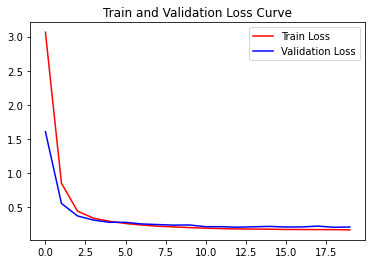

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [30]:
#Evaluate the model
score = model.evaluate(X_test_array, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20773091912269592
Test accuracy: 0.03308026120066643


In [ ]:
model.save('collaborative_model.h5')

## Creating RMSE function for Neural Network

In [20]:
def root_mean_squared_error(y_test, y_train):
        return K.sqrt(K.mean(K.square(y_test - y_train))) 

In [25]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
     
# add fully-connected-layers
fc1 = Dense(256, activation='relu')(x)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = tf.keras.layers.Dropout(0.1)(fc2)
out = Dense(1)(fc3)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer = opt , loss = root_mean_squared_error, metrics=['accuracy'])

NameError: name 'root_mean_squared_error' is not defined

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 240)       2212560     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 240)       397680      ['input_4[0][0]']                
                                                                                            

In [23]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
116/116 [==============================] - 13s 98ms/step - loss: 4.1236 - accuracy: 0.0000e+00 - val_loss: 4.1165 - val_accuracy: 0.0000e+00
Epoch 2/20
116/116 [==============================] - 11s 97ms/step - loss: 4.0922 - accuracy: 0.0000e+00 - val_loss: 4.0861 - val_accuracy: 0.0000e+00
Epoch 3/20
116/116 [==============================] - 11s 98ms/step - loss: 4.0608 - accuracy: 0.0000e+00 - val_loss: 4.0555 - val_accuracy: 0.0000e+00
Epoch 4/20
116/116 [==============================] - 12s 100ms/step - loss: 4.0291 - accuracy: 0.0000e+00 - val_loss: 4.0243 - val_accuracy: 0.0000e+00
Epoch 5/20
116/116 [==============================] - 12s 102ms/step - loss: 3.9961 - accuracy: 0.0000e+00 - val_loss: 3.9924 - val_accuracy: 0.0000e+00
Epoch 6/20
116/116 [==============================] - 12s 99ms/step - loss: 3.9630 - accuracy: 0.0000e+00 - val_loss: 3.9595 - val_accuracy: 0.0000e+00
Epoch 7/20
116/116 [==============================] - 12s 101ms/step - loss: 3.9282 - 

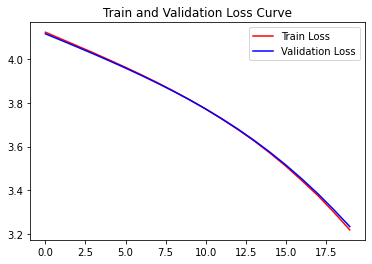

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [1]:
#Evaluate the model
score = model.evaluate(X_test_array, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'model' is not defined

# Making Recommendations

In [74]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(df.Item_id)))
hotel_data[:5]

array([0, 1, 2, 3, 4])

In [75]:
user = np.array([1 for i in range(len(hotel_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [76]:
predictions = model.predict([user, hotel_data])

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()[:5]

recommended_item_ids

array([72, 49, 59, 19, 36], dtype=int64)

In [77]:
# print predicted scores
predictions[recommended_item_ids]

array([0.19043083, 0.18687372, 0.18581037, 0.18546915, 0.18278559],
      dtype=float32)

# Recommend Hotel Cluster for a User

In [99]:
rows = []
hotel = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)
names = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'Item_id' : hotel[i], 'User_id' : 1048}))
test_data = pd.DataFrame(rows)

In [100]:
for idx, (score, name) in enumerate(sorted(zip(recommended_item_ids, names), reverse=True)):
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  72.0  for hotel cluster:  1
Score:  59.0  for hotel cluster:  21
Score:  49.0  for hotel cluster:  80
Score:  36.0  for hotel cluster:  41
Score:  19.0  for hotel cluster:  92


In [41]:
hotel_data = np.array(list(set(df['item'])))
hotel_data[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
id_user = 20
user = np.array([id_user for i in range (len(hotel_data))])
user[:10]

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [43]:
predictions = model.predict([user, hotel_data])
predictions = np.array([a[0] for a in predictions])
recommended_hotel_id = (-predictions).argsort()[:10]
recommended_hotel_id

45/45 [==============================] - 0s 5ms/step


array([  6,  83, 138,  21,  84,   4,  62, 115,  77,  34])

In [44]:
predictions[recommended_hotel_id]

array([4.595995 , 4.157644 , 3.9491413, 3.9372382, 3.914852 , 3.8839493,
       3.7683673, 3.7665148, 3.7572596, 3.6514044], dtype=float32)